# 🎯 DeBERTa-v3 Sentiment Analysis Training

Train a 3-class sentiment classifier (negative, neutral, positive) using `microsoft/deberta-v3-base`.

**Exports:** `.pt` (PyTorch) and `.onnx` (ONNX) formats for local application use.

## 1. Setup & Configuration

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dependencies
!pip install -q transformers datasets accelerate scikit-learn onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
# ⚠️ UPDATE THIS PATH to your CSV file in Google Drive
DATASET_PATH = "/content/drive/MyDrive/Datasets/train.csv"

# Output directory for trained model (in Drive)
OUTPUT_DIR = "/content/drive/MyDrive/Datasets"

# Model configuration
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Data Loading & Exploration

In [ ]:
# Load dataset
df = pd.read_csv(DATASET_PATH, encoding='latin1')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (27481, 10)

Columns: ['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


Sentiment Distribution:
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

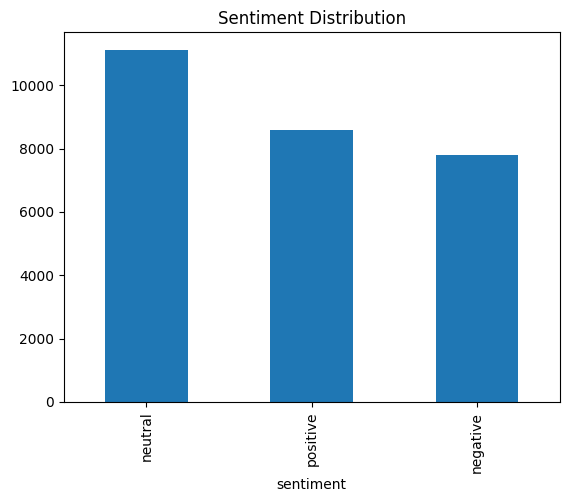

In [ ]:
# Check sentiment distribution
print("Sentiment Distribution:")
print(df['sentiment'].value_counts())
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

## 3. Data Cleaning

In [ ]:
# Keep only relevant columns
df_clean = df[['text', 'sentiment']].copy()
print(f"Before cleaning: {len(df_clean)} rows")

# Remove missing values
df_clean = df_clean.dropna(subset=['text', 'sentiment'])
print(f"After removing nulls: {len(df_clean)} rows")

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['text'])
print(f"After removing duplicates: {len(df_clean)} rows")

# Clean text (strip whitespace, ensure string type)
df_clean['text'] = df_clean['text'].astype(str).str.strip()

# Remove empty texts
df_clean = df_clean[df_clean['text'].str.len() > 0]
print(f"After removing empty texts: {len(df_clean)} rows")

# Standardize sentiment labels to lowercase
df_clean['sentiment'] = df_clean['sentiment'].str.lower().str.strip()

print(f"\nFinal sentiment distribution:")
print(df_clean['sentiment'].value_counts())

Before cleaning: 27481 rows
After removing nulls: 27480 rows
After removing duplicates: 27480 rows
After removing empty texts: 27480 rows

Final sentiment distribution:
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


## 4. Preprocessing

In [ ]:
# Create label mapping
LABEL_MAP = {'negative': 0, 'neutral': 1, 'positive': 2}
ID_TO_LABEL = {v: k for k, v in LABEL_MAP.items()}

# Encode labels
df_clean['label'] = df_clean['sentiment'].map(LABEL_MAP)

# Check for unmapped labels
if df_clean['label'].isna().any():
    unmapped = df_clean[df_clean['label'].isna()]['sentiment'].unique()
    print(f"⚠️ Warning: Unmapped sentiment values found: {unmapped}")
    df_clean = df_clean.dropna(subset=['label'])

df_clean['label'] = df_clean['label'].astype(int)
print(f"Label distribution:\n{df_clean['label'].value_counts().sort_index()}")

Label distribution:
label
0     7781
1    11117
2     8582
Name: count, dtype: int64


In [ ]:
# Split data: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df_clean, test_size=0.2, stratify=df_clean['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

Train: 21984 | Validation: 2748 | Test: 2748


In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False  # Dynamic padding in DataCollator
    )

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

print(f"Tokenized train sample: {train_dataset[0]}")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

Tokenized train sample: {'label': 1, 'input_ids': [1, 2298, 9043, 67623, 5459, 277, 1741, 423, 260, 325, 5459, 268, 343, 260, 14771, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## 5. Model Training

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=ID_TO_LABEL,
    label2id=LABEL_MAP
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'f1_weighted': f1_score(labels, predictions, average='weighted')
    }

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    report_to="none",
    seed=42
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Starting training...")

Starting training...


In [ ]:
# Train the model
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.501700,0.498572,0.805677,0.808621,0.805935
2,0.437100,0.524396,0.808952,0.812380,0.808345
3,0.361200,0.566615,0.805677,0.808937,0.805373


TrainOutput(global_step=4122, training_loss=0.4597038933514739, metrics={'train_runtime': 614.789, 'train_samples_per_second': 107.276, 'train_steps_per_second': 6.705, 'total_flos': 1297287526242240.0, 'train_loss': 0.4597038933514739, 'epoch': 3.0})

## 6. Evaluation

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print(f"\nTest Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

Evaluating on test set...



Test Results:
  eval_loss: 0.5415
  eval_accuracy: 0.7933
  eval_f1_macro: 0.7972
  eval_f1_weighted: 0.7925
  eval_runtime: 5.8469
  eval_samples_per_second: 469.9960
  eval_steps_per_second: 29.4180
  epoch: 3.0000


In [ ]:
# Get predictions for detailed metrics
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['negative', 'neutral', 'positive']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(labels, preds)
print(cm)


Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.86      0.80       778
     neutral       0.79      0.71      0.75      1112
    positive       0.86      0.84      0.85       858

    accuracy                           0.79      2748
   macro avg       0.80      0.80      0.80      2748
weighted avg       0.80      0.79      0.79      2748


Confusion Matrix:
[[672  92  14]
 [215 791 106]
 [ 17 124 717]]


## 7. Export Model

In [ ]:
# Create export directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save HuggingFace model and tokenizer
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"✅ Model saved to: {OUTPUT_DIR}")

✅ Model saved to: /content/drive/MyDrive/Datasets


In [ ]:
# Save label mapping
label_map_path = os.path.join(OUTPUT_DIR, "label_map.json")
with open(label_map_path, 'w') as f:
    json.dump({
        'label_to_id': LABEL_MAP,
        'id_to_label': ID_TO_LABEL
    }, f, indent=2)
print(f"✅ Label map saved to: {label_map_path}")

✅ Label map saved to: /content/drive/MyDrive/Datasets/label_map.json


In [ ]:
# Export to PyTorch .pt format
pt_path = os.path.join(OUTPUT_DIR, "sentiment_model.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model.config.to_dict(),
    'label_map': LABEL_MAP,
    'id_to_label': ID_TO_LABEL
}, pt_path)
print(f"✅ PyTorch model saved to: {pt_path}")

✅ PyTorch model saved to: /content/drive/MyDrive/Datasets/sentiment_model.pt


In [ ]:
# Export to ONNX format

!pip install onnxscript # Install missing dependency

onnx_path = os.path.join(OUTPUT_DIR, "sentiment_model.onnx")

# Prepare dummy input for ONNX export
model.eval()
model.to('cpu')

dummy_input = tokenizer(
    "This is a sample text for export",
    return_tensors="pt",
    max_length=MAX_LENGTH,
    truncation=True,
    padding="max_length"
)

# Export to ONNX
torch.onnx.export(
    model,
    (dummy_input['input_ids'], dummy_input['attention_mask']),
    onnx_path,
    input_names=['input_ids', 'attention_mask'],
    output_names=['logits'],
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_length'},
        'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
        'logits': {0: 'batch_size'}
    },
    opset_version=14
)
print(f"✅ ONNX model saved to: {onnx_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 10.6 MB/s eta 0:00:00


W0118 18:46:53.332000 833 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 14 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `DebertaV2ForSequenceClassification([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DebertaV2ForSequenceClassification([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


KeyboardInterrupt: 

In [ ]:
# Verify ONNX export
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✅ ONNX model verified successfully!")

## 8. Test Inference (Sample)

In [ ]:
# Test inference with the trained model
def predict_sentiment(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    pred_id = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][pred_id].item()

    return {
        'text': text,
        'sentiment': ID_TO_LABEL[pred_id],
        'confidence': f"{confidence:.2%}",
        'probabilities': {
            'negative': f"{probs[0][0].item():.2%}",
            'neutral': f"{probs[0][1].item():.2%}",
            'positive': f"{probs[0][2].item():.2%}"
        }
    }

# Test samples
test_texts = [
    "I love this product! It's amazing!",
    "This is the worst experience ever.",
    "The product is okay, nothing special."
]

print("Sample Predictions:")
print("-" * 50)
for text in test_texts:
    result = predict_sentiment(text, model, tokenizer)
    print(f"Text: {result['text']}")
    print(f"Sentiment: {result['sentiment']} ({result['confidence']})")
    print(f"Probabilities: {result['probabilities']}")
    print("-" * 50)

## ✅ Training Complete!

**Exported files in your Google Drive:**
- `sentiment_model.pt` - PyTorch checkpoint
- `sentiment_model.onnx` - ONNX model for inference
- `label_map.json` - Label mapping (0=negative, 1=neutral, 2=positive)
- `config.json`, `model.safetensors`, `tokenizer.json` - HuggingFace format